In [73]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.layers import Conv1D, BatchNormalization, AveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.saving import save_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [74]:
df = pd.read_csv('model_data_1min.csv')
df.head()

,Unnamed: 0,trade_id,product_id,price,size,time,side,bid,ask,exchange,...,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,60305,590641283,ETH-USD,3598.16,0.013755,2025-01-04 06:38:20.767435+00:00,SELL,NaN,NaN,NaN,...,36308.0,36308.0,36308.0,36308.0,36308.0,36308.0,227275.0,227275.0,143784.0,60293.0
1,60304,590641310,ETH-USD,3598.95,0.002479,2025-01-04 06:38:35.543964+00:00,SELL,NaN,NaN,NaN,...,36309.0,36309.0,36309.0,36309.0,36309.0,36309.0,227274.0,227274.0,143783.0,60292.0
2,60303,590641344,ETH-USD,3598.15,3.565571,2025-01-04 06:38:55.779501+00:00,BUY,NaN,NaN,NaN,...,36310.0,36310.0,36310.0,36310.0,36310.0,36310.0,227273.0,227273.0,143782.0,60291.0
3,60302,590641361,ETH-USD,3597.71,0.000987,2025-01-04 06:39:14.353069+00:00,BUY,NaN,NaN,NaN,...,36311.0,36311.0,36311.0,36311.0,36311.0,36311.0,227272.0,227272.0,143781.0,60290.0
4,60301,590641382,ETH-USD,3597.72,0.200000,2025-01-04 06:39:29.902680+00:00,SELL,NaN,NaN,NaN,...,36312.0,36312.0,36312.0,36312.0,36312.0,36312.0,227271.0,227271.0,143780.0,60289.0


In [75]:
#data set is one datapoint every 15 seconds. Want to look once every 3 minutes instead. So we're going to limit our dataset as such
# Make sure 'time' is a datetime object
df['time'] = pd.to_datetime(df['time'])

# Set it as index
df.set_index('time', inplace=True)

# Resample every 6 minutes
minute = 12
df_resampled = df.resample(f'{minute}T').agg({
    'price': 'last',  # Last traded price in the interval
    'size': 'sum',    # Total volume traded in the interval
    'side': lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN'  # Most common side or fallback
})

#x = 4000 #start data a 3/1

# Grab everything after (and including) the 83,000th row
#df_resampled = df_resampled.iloc[x:]

df_resampled = df_resampled.reset_index()
df_resampled.head()
df_resampled.to_csv('resampled_data.csv')

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_88661/991056651.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(f'{minute}T').agg({


In [76]:
df_resampled.head()

,time,price,size,side
0,2025-01-04 06:36:00+00:00,3594.34,6.551917,SELL
1,2025-01-04 06:48:00+00:00,3598.94,2.166045,SELL
2,2025-01-04 07:00:00+00:00,3604.52,6.454355,SELL
3,2025-01-04 07:12:00+00:00,3599.73,15.299945,SELL
4,2025-01-04 07:24:00+00:00,3601.35,9.520276,SELL


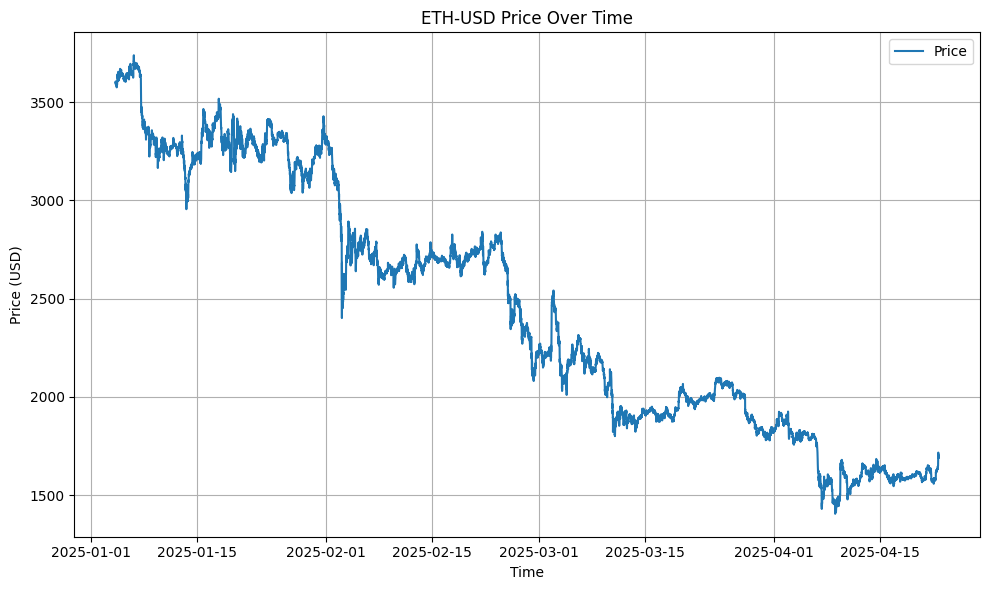

In [77]:
df_trades = df_resampled

# Convert 'price' column to numeric
df_trades['price'] = pd.to_numeric(df_trades['price'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_trades['time'], df_trades['price'], linestyle='-', label='Price')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('ETH-USD Price Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
# Ensure time column is sorted
df_trades = df_trades.sort_values('time')

# Scale the 'price' and 'size' column
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])

# Create sequences of data for LSTM
sequence_length = 10  # Sequence of 10 observations
forecast_steps = 5     # Predict 5 steps into the future

In [79]:
# Compute percent   difference
df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage

# Drop the first row since pct_change for first row is NaN
df_trades = df_trades.dropna(subset=['pct_change']).reset_index(drop=True)

df_trades = df_trades.drop(columns=[col for col in df_trades.columns if col.startswith("Unnamed")])

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_88661/1791461416.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage


In [80]:
df_trades['sma_5'] = df_trades['price_scaled'].rolling(window=5).mean()
df_trades['momentum'] = df_trades['price_scaled'] - df_trades['price_scaled'].shift(5)
df_trades.dropna(subset=['sma_5', 'momentum'], inplace=True)
df_trades.head()

,time,price,size,side,price_scaled,pct_change,sma_5,momentum
5,2025-01-04 07:48:00+00:00,3592.58,9.574716,SELL,0.937762,-0.175609,0.940693,-0.002727
6,2025-01-04 08:00:00+00:00,3600.20,4.764039,SELL,0.941029,0.212104,0.940323,-0.001853
7,2025-01-04 08:12:00+00:00,3595.58,4.483896,SELL,0.939048,-0.128326,0.939967,-0.001780
8,2025-01-04 08:24:00+00:00,3597.75,7.692453,SELL,0.939979,0.060352,0.939658,-0.001544
9,2025-01-04 08:36:00+00:00,3585.29,19.931080,SELL,0.934635,-0.346328,0.938491,-0.005837


In [81]:

from sklearn.preprocessing import OneHotEncoder

sequence_length = 60
forecast_steps = 3

X = []
y = []

# Generate binary inputs: 0 if price went down, 1 if up
price_changes = (df_trades['price_scaled'].diff() > 0).astype(int).values

# Normalize prices for use in label logic
prices = df_trades['price'].values

for i in range(len(prices) - sequence_length - forecast_steps):
    # Inputs: binary price movement over last `sequence_length` steps
    X.append(price_changes[i:i + sequence_length])

    # Determine price movement for target
    current_price = prices[i + sequence_length]
    future_price = prices[i + sequence_length + forecast_steps]
    pct_change = (future_price - current_price) / current_price

    if pct_change > 0.001:
        label = 2  # BUY
    elif pct_change < -0.001:
        label = 0  # SELL
    else:
        label = 1  # HOLD

    y.append(label)

X = np.array(X).reshape(-1, sequence_length, 1)  # Reshape for CNN 1D input
y = np.array(y).reshape(-1, 1)

# One-hot encode both inputs and outputs
encoder_y = OneHotEncoder(sparse_output=False)
y = encoder_y.fit_transform(y)
print("One-hot encoded labels shape:", y.shape)


One-hot encoded labels shape: (12937, 3)


In [82]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [83]:
print(np.sum(y_test, axis=0))  # if y is one-hot

[1028.  518. 1042.]


In [84]:
X_train.shape

(10349, 60, 1)

In [85]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # CNN Layer
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    AveragePooling1D(pool_size=1),
    Dropout(0.5),

    # First LSTM Layer
    LSTM(128, return_sequences=True, activation='tanh'),
    BatchNormalization(),
    Dropout(0.5),

    # Second LSTM Layer
    LSTM(80, activation='tanh'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 58, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_5             │ (None, 58, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 58, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 58, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 58, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 58, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 80)             │        66,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,283 (653.45 KB)

 Trainable params: 166,739 (651.32 KB)

 Non-trainable params: 544 (2.12 KB)

In [86]:
# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.3480 - loss: 0.8659 - val_accuracy: 0.3872 - val_loss: 0.6174
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.3891 - loss: 0.6734 - val_accuracy: 0.3841 - val_loss: 0.6185
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.4010 - loss: 0.6367 - val_accuracy: 0.3733 - val_loss: 0.6198
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.4040 - loss: 0.6229 - val_accuracy: 0.3810 - val_loss: 0.6212
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.3964 - loss: 0.6222 - val_accuracy: 0.3825 - val_loss: 0.6188
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.4050 - loss: 0.6203 - val_accuracy: 0.3910 - val_loss: 0.6167
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.3997 - loss: 0.6177 - val_accuracy: 0.3775 - val_loss: 0.6196
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.4152 - loss: 

In [87]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=['SELL', 'HOLD', 'BUY']))

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
              precision    recall  f1-score   support

        SELL       0.38      0.41      0.40      1028
        HOLD       0.00      0.00      0.00       518
         BUY       0.40      0.56      0.47      1042

    accuracy                           0.39      2588
   macro avg       0.26      0.33      0.29      2588
weighted avg       0.31      0.39      0.35      2588



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  